In [67]:
from svdunfold import SVDunfold
import svdunfold
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.signal import fftconvolve
from matplotlib.colors import LogNorm
from scipy import stats
import random
from scipy.interpolate import interp1d

In [121]:
nevents=100000
x0 = 1842 # M2
gamma0 = 6
x1 =  2047 # M1
gamma1 = 13.2
mu = 14.49
sigma=0.05
gaussian_par=[mu,sigma]
cauchy_par_0=[x0,gamma0]
cauchy_par_1=[x1,gamma1]

cauchy_par_test_0=[x0-10,gamma0+1]
cauchy_par_test_1=[x1+20,gamma1-1]

x_min=1400
x_max=2500
x_nbins=220
b_min=1400
b_max=2500
b_nbins=220
nevents_test_0=nevents-40000
nevents_test_1=nevents+100000

class ExampleProblem:
    def __init__(self):
        pass

    def set_bins_x_ini(self, n_bins_x, bin_low_x, bin_high_x):
        self.n_bins_x = n_bins_x
        self.__bin_low_x, self.__bin_high_x = bin_low_x, bin_high_x
        self.bins_x, self.bin_centers_x = self.__bins_and_centers(
            n_bins_x, bin_low_x, bin_high_x)

    def set_bins_b_ini(self, n_bins_b, bin_low_b, bin_high_b):
        self.n_bins_b = n_bins_b
        self.__bin_low_b, self.__bin_high_b = bin_low_b, bin_high_b
        self.bins_b, self.bin_centers_b = self.__bins_and_centers(
            n_bins_b, bin_low_b, bin_high_b)

    def setup_example(self):
        self.__generate_initial_MC()
        self.__b_ini_gen = self.__generate_data(self.__x_ini_gen)
        self.__generate_test_distribution()
        self.__b_test_gen = self.__generate_data(self.__x_test_gen)
        self.__generate_response_matrix()
        self.__B = self.__build_diagonal_covariance(self.__b_test_gen)

    def get_initial_MC(self):
        return self.__x_ini_gen

    def get_initial_MC_data(self):
        return self.__b_ini_gen

    def get_response_matrix(self):
        return self.__A

    def get_test_distribution(self):
        return self.__x_test_gen

    def get_test_data(self):
        return self.__b_test_gen

    def get_test_data_covariance(self):
        return self.__B

    def true_distribution(self, x):
        peak1_integral = self.__histogram_integral(self.__x_ini_1)
        peak2_integral = self.__histogram_integral(self.__x_ini_2)
        return peak1_integral * stats.cauchy.pdf(x, cauchy_par_0[0], cauchy_par_0[1]) + peak2_integral * stats.cauchy.pdf(x, cauchy_par_1[0], cauchy_par_1[1])

    def test_distribution(self, x):
        peak1_integral = self.__histogram_integral(self.__x_test_1)
        peak2_integral = self.__histogram_integral(self.__x_test_2)
        return peak1_integral * stats.cauchy.pdf(x, cauchy_par_test_0[0], cauchy_par_test_0[1]) + peak2_integral * stats.cauchy.pdf(x, cauchy_par_test_1[0], cauchy_par_test_1[1])

    def __generate_initial_MC_peak1(self):
        self.__x_ini_1 = stats.cauchy.rvs(
            cauchy_par_0[0], cauchy_par_0[1], nevents)

    def __generate_initial_MC_peak2(self):
        self.__x_ini_2 = stats.cauchy.rvs(
            cauchy_par_1[0], cauchy_par_1[1], nevents)

    def __histogram_integral(self, gen_distr):
        hist = np.histogram(gen_distr, self.bins_x)
        integral = hist[0].sum() * (hist[1][1] - hist[1][0])
        return integral

    def __generate_initial_MC(self):
        self.__generate_initial_MC_peak1()
        self.__generate_initial_MC_peak2()
        self.__x_ini_gen = np.append(self.__x_ini_1, self.__x_ini_2)

    def __generate_test_distribution_peak1(self):
        self.__x_test_1 = stats.cauchy.rvs(
            cauchy_par_test_0[0], cauchy_par_test_0[1], nevents_test_0)

    def __generate_test_distribution_peak2(self):
        self.__x_test_2 = stats.cauchy.rvs(
            cauchy_par_test_1[0], cauchy_par_test_1[1], nevents_test_1)

    def __generate_test_distribution(self):
        self.__generate_test_distribution_peak1()
        self.__generate_test_distribution_peak2()
        self.__x_test_gen = np.append(self.__x_test_1, self.__x_test_2)

    def __generate_data(self, x):
        b_gen = []
        for i in x:
            b_gen.append(self.__add_smearing(i))
        return b_gen

    def __generate_response_matrix(self):
        self.__A = np.histogram2d(self.__x_ini_gen, self.__b_ini_gen, bins=[
            self.bins_x, self.bins_b])

    def __build_diagonal_covariance(self, data_gen):
        data = np.histogram(data_gen, bins=self.n_bins_b, range=(
            self.__bin_low_b, self.__bin_high_b))[0]
        B = np.zeros(shape=(self.n_bins_b, self.n_bins_b))
        std_dev = np.sqrt(data)
        for i in range(self.n_bins_b):
            B[i, i] = std_dev[i] * std_dev[i]
        return B

    def __bins_and_centers(self, nbins, low, high):
        bins = np.linspace(low, high, nbins + 1)
        bin_centers = (bins + (bins[1] - bins[0]) / 2)[:-1]
        return bins, bin_centers

    def __add_smearing(self, x):
        smear = np.random.normal(gaussian_par[0],gaussian_par[1])
        return x + smear


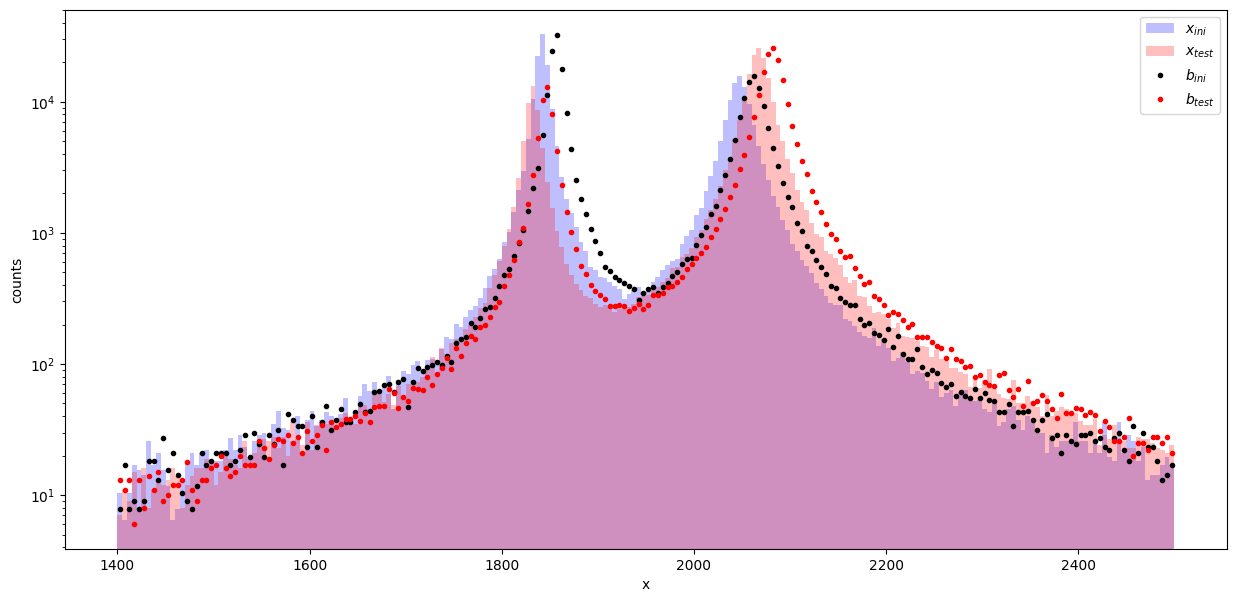

In [128]:
exampleProblem = ExampleProblem()
exampleProblem.set_bins_x_ini(x_nbins, x_min, x_max)
exampleProblem.set_bins_b_ini(b_nbins, b_min, b_max)
exampleProblem.setup_example()
x_ini_gen = exampleProblem.get_initial_MC()
x_ini = np.histogram(x_ini_gen, exampleProblem.bins_x)
x_test_gen = exampleProblem.get_test_distribution()
x_test = np.histogram(x_test_gen, exampleProblem.bins_x)

scale_factor = len(x_test_gen)/len(x_ini_gen)

b_ini_gen = exampleProblem.get_initial_MC_data()
b_ini = np.histogram(b_ini_gen, exampleProblem.bins_b)
b_test_gen = exampleProblem.get_test_data()
b_test = np.histogram(b_test_gen, exampleProblem.bins_b)

plt.figure(figsize=(15, 7))

plt.hist(x_ini_gen, density=False, bins=exampleProblem.bins_x, histtype="stepfilled", color="blue", 
         label="$x_{ini}$", alpha=0.25, weights=scale_factor*np.ones(len(x_ini_gen)))
plt.hist(x_test_gen, density=False, bins=exampleProblem.bins_x, histtype="stepfilled", color="red", label="$x_{test}$", alpha=0.25)
plt.plot(exampleProblem.bin_centers_b, b_ini[0]*scale_factor, ".", color="black", label="$b_{ini}$")
plt.plot(exampleProblem.bin_centers_b, b_test[0], ".", color="red", label="$b_{test}$")

plt.xlabel("x")
plt.ylabel("counts")
plt.legend()
plt.yscale("log")
#x = np.linspace(exampleProblem.bins_x[0], exampleProblem.bins_x[-1], 1000)
#plt.plot(x, exampleProblem.true_distribution(x)*scale_factor)
#plt.plot(x, exampleProblem.test_distribution(x))

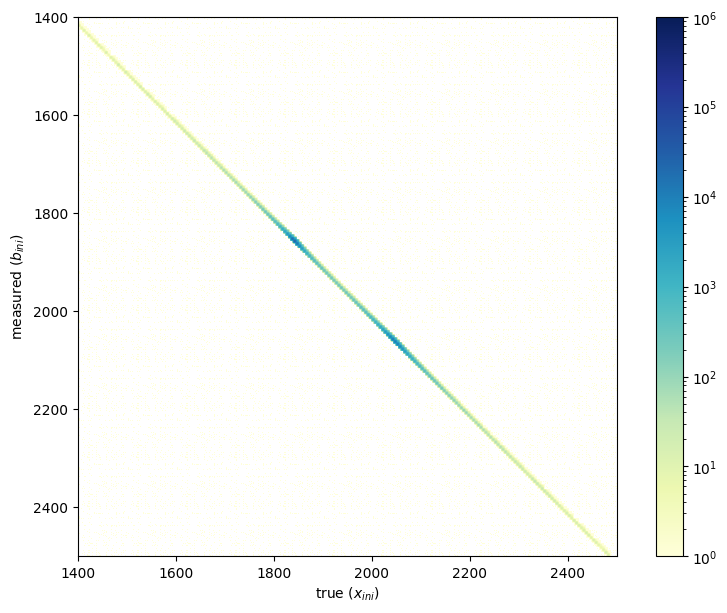

In [123]:
A = exampleProblem.get_response_matrix()[0].T

plt.figure(figsize=(10, 7))

plt.imshow((A), norm=LogNorm(vmin=1, vmax=1e6), cmap="YlGnBu",\
           extent=[exampleProblem.bins_x[0], exampleProblem.bins_x[-1],exampleProblem.bins_b[-1],exampleProblem.bins_b[0]])
plt.xlabel("true ($x_{ini}$)")
plt.ylabel("measured ($b_{ini}$)")
plt.colorbar()

Text(0, 0.5, 'measured ($b_{ini}$)')

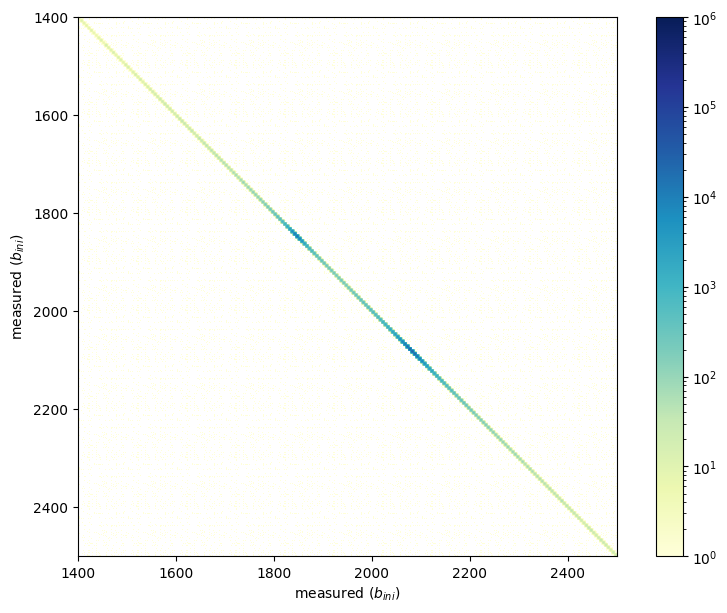

In [124]:
B = exampleProblem.get_test_data_covariance()

plt.figure(figsize=(10, 7))

plt.imshow(B, norm=LogNorm(vmin=1, vmax=1e6), cmap="YlGnBu",\
           extent=[exampleProblem.bins_b[0], exampleProblem.bins_b[-1],exampleProblem.bins_b[-1],exampleProblem.bins_b[0]])
plt.colorbar()
plt.xlabel("measured ($b_{ini}$)")
plt.ylabel("measured ($b_{ini}$)")

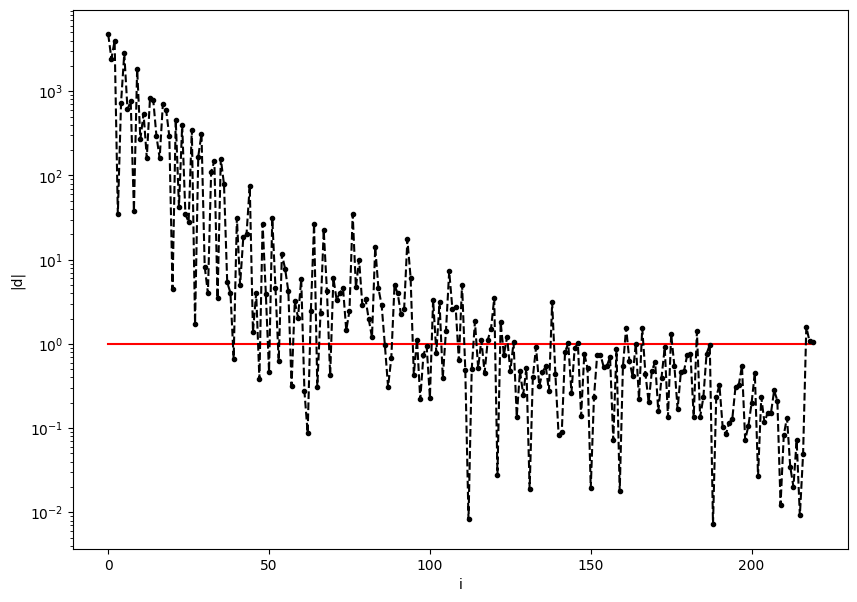

In [125]:
unfold = svdunfold.SVDunfold(x_ini, b_test, A, B, x_min,x_max,b_min,b_max, 0.001)
unfold.pre_unfolding()
d = unfold.get_abs_d()

plt.figure(figsize=(10, 7))

plt.plot(np.arange(len(d)), np.ones(len(d)), "r-" )
plt.plot(np.arange(len(d)), d, "k.--")
plt.xlabel("i")
plt.ylabel("|d|")
plt.yscale("log")

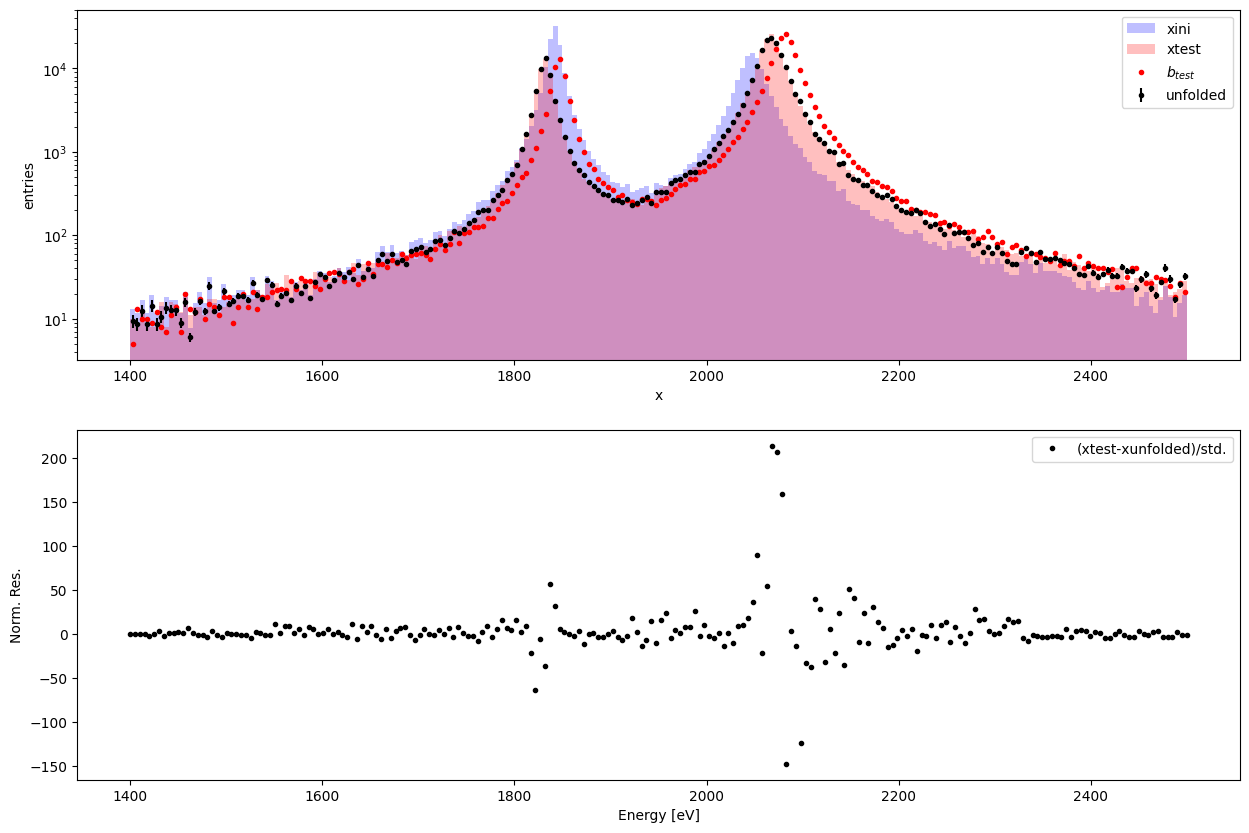

In [126]:
unfold.unfolding(40)

x = unfold.get_x_unfolded()
X = unfold.get_X_unfolded_covariance()

plt.subplots(2 , 1, figsize=(15, 10))
plt.subplot(2,1,1)
plt.hist(x_ini_gen, density=False, bins=exampleProblem.bins_x, histtype="stepfilled", color="blue", 
         alpha=0.25, weights=scale_factor*np.ones(len(x_ini_gen)) ,label="xini")
plt.hist(x_test_gen, density=False, bins=exampleProblem.bins_x,  label="xtest",histtype="stepfilled", color="red", alpha=0.25)
plt.errorbar(exampleProblem.bin_centers_x, x, fmt="k.", yerr=np.sqrt(np.diagonal(X)), label="unfolded")
aa = np.linspace(x_min, x_max, x_nbins)
plt.plot(exampleProblem.bin_centers_b, b_test[0], ".", color="red", label="$b_{test}$")

plt.xlabel("x")
plt.ylabel("entries")
plt.yscale("log")
plt.legend()
plt.subplot(2,1,2)
plt.plot(aa,(x_test[0]-x)/np.sqrt(np.diag(X)), marker='.', linestyle="", color="black", label="(xtest-xunfolded)/std.")
plt.xlabel("Energy [eV]")
plt.legend()
plt.ylabel("Norm. Res.")
plt.savefig("{}eVRMS_binwidth{}.pdf".format(sigma, (x_max-x_min)/x_nbins))